<a href="https://colab.research.google.com/github/anandpuntambekar/Binary_Image_Classiff_cats_dogs/blob/master/Hangman_attempt_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#4 working

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import random
import re
import collections
#torch.autograd.set_detect_anomaly(True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 48)
        self.fc3 = nn.Linear(48, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class HangmanDQL:
    def __init__(self, word_list):
        self.word_list = word_list
        self.epsilon = 0.2
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001 #0.00055 #0.001
        self.model = QNetwork(26 + 29+5, 26).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        self.MAX_CHANCES = 10

    def get_state(self, word, used_letters,incorrect_guesses):
        state = [1 if char in used_letters else 0 for char in 'abcdefghijklmnopqrstuvwxyz']
        #word_encoding = [1 if char == "_" else 0 for char in word]
        word_encoding = [1 if char == "_" else 0 for char in word] + [0] * (29 - len(word))
        # a. Length of the word being guessed
        word_length = len(word)

        # b. Count of correct letters guessed in the current word state
        correct_letter_count = sum(word.count(letter) for letter in set(word) if letter != '_')

        # c. Total positions correctly guessed
        correct_positions = len(word) - word_encoding.count(1)

        # d. Total guesses pending
        guesses_pending = len(word) - correct_positions

        # e. Total chances pending
        chances_pending = self.MAX_CHANCES - incorrect_guesses

        state_representation = state + word_encoding
        #print("State representation length:", len(state_representation))

        state_representation = state + word_encoding + [word_length, correct_letter_count, correct_positions, guesses_pending, chances_pending]

        return torch.tensor(state_representation, dtype=torch.float32).unsqueeze(0).to(device)

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return chr(np.random.choice(range(97, 123)))
        with torch.no_grad():
            q_values = self.model(state)
        return chr(torch.argmax(q_values).item() + 97)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = np.random.choice(len(self.memory), batch_size)
        for i in minibatch:
            state, action, reward, next_state, done = self.memory[i]
            target_q_values = self.model(state)
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)).item()
                target_q_values[0][ord(action) - 97] = target  # Update target_q_values here
            else:
                target_q_values[0][ord(action) - 97] = reward
            predicted_q_values = self.model(state)
            loss = self.criterion(predicted_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, epochs=1000, batch_size=32):

        for _ in range(epochs):
            #print('Epoch:',_)
            print(f'Training Epoch: {_ + 1}/{epochs}')
            word = np.random.choice(self.word_list)
            guessed_word = ["_"] * len(word)
            used_letters = []
            incorrect_guesses=0
            done = False

            while not done:
                state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                action = self.choose_action(state)
                used_letters.append(action)

                if action in word:
                    for i, letter in enumerate(word):
                        if letter == action:
                            guessed_word[i] = action
                    reward = 1
                else:
                    reward = -1 #* (1 + incorrect_guesses * 0.1)
                    incorrect_guesses += 1

                if "_" not in guessed_word or len(used_letters) > 10:
                    done = True

                next_state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                self.remember(state, action, reward, next_state, done)

                if len(self.memory) > batch_size:
                    self.replay(batch_size)
            success_rate = self.test(games=500)
            #print(f"Success Rate after Epoch {_ + 1}: {success_rate:.2%}")

    def find_learning_rate(self, init_value=1e-8, final_value=10., beta=0.98):
        num = len(self.memory) - 1
        mult = (final_value / init_value) ** (1/num)
        lr = init_value
        self.optimizer.param_groups[0]['lr'] = lr
        avg_loss = 0.
        best_loss = 0.
        batch_num = 0
        losses = []
        log_lrs = []
        for data in self.memory:
            batch_num += 1
            # Get a mini-batch of training data
            state, action, reward, next_state, done = data
            target = reward
            if not done:
                target = reward + self.gamma * torch.max(self.model(next_state)).item()
            target_q_values = self.model(state)
            target_q_values[0][ord(action) - 97] = target
            predicted_q_values = self.model(state)
            loss = self.criterion(predicted_q_values, target_q_values)

            # Smooth the average and compute the smoothed loss
            avg_loss = beta * avg_loss + (1-beta) *loss.item()
            smoothed_loss = avg_loss / (1 - beta**batch_num)

            # Stop if the loss is exploding
            if batch_num > 1 and smoothed_loss > 4 * best_loss:
                return log_lrs, losses
            # Record the best loss
            if smoothed_loss < best_loss or batch_num==1:
                best_loss = smoothed_loss

            # Store the values
            losses.append(smoothed_loss)
            log_lrs.append(np.log10(lr))

            # Update the learning rate
            lr *= mult
            self.optimizer.param_groups[0]['lr'] = lr

            # Perform the optimization step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        return log_lrs, losses

    def plot_lr_finder(self, log_lrs, losses):
        plt.plot(log_lrs, losses)
        plt.xlabel("Log10 Learning Rate")
        plt.ylabel("Loss")
        plt.title("Learning Rate Finder")
        plt.show()

    def populate_memory(self, games=500):
        for _ in range(games):
            word = np.random.choice(self.word_list)
            guessed_word = ["_"] * len(word)
            used_letters = []
            incorrect_guesses = 0  # Initialize it here
            done = False

            while not done:
                state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                #print("State shape:", state.shape)
                action = self.choose_action(state)
                used_letters.append(action)

                if action in word:
                    for i, letter in enumerate(word):
                        if letter == action:
                            guessed_word[i] = action
                    reward = 1
                else:
                    reward = -1

                if "_" not in guessed_word or len(used_letters) > 10:
                    done = True

                next_state = self.get_state("".join(guessed_word), used_letters,incorrect_guesses)
                self.remember(state, action, reward, next_state, done)
                #print(state.shape)
                #print(26 + len(max(self.word_list, key=len)))

    def test(self, games=100):
      total_success = 0

      for _ in range(games):
          word = np.random.choice(self.word_list)
          guessed_word = ["_"] * len(word)
          used_letters = []
          incorrect_guesses = 0
          game_over = False

          while not game_over:
              state = self.get_state("".join(guessed_word), used_letters, incorrect_guesses)
              q_values = self.model(state).detach().cpu().numpy()  # Get Q-values for actions

              # Exclude already used letters
              for used_letter in used_letters:
                  q_values[0][ord(used_letter) - 97] = -np.inf

              action = chr(np.argmax(q_values) + 97)
              used_letters.append(action)

              if action in word:
                  for i, letter in enumerate(word):
                      if letter == action:
                          guessed_word[i] = action
              else:
                incorrect_guesses += 1  # Increment the counter if the guess was incorrect


              game_over = "_" not in guessed_word or len(used_letters) > 10

          # Check if the game was a success
          if "_" not in guessed_word:
              total_success += 1

      print(f"Success rate: {total_success/games:.2%}")
      return total_success

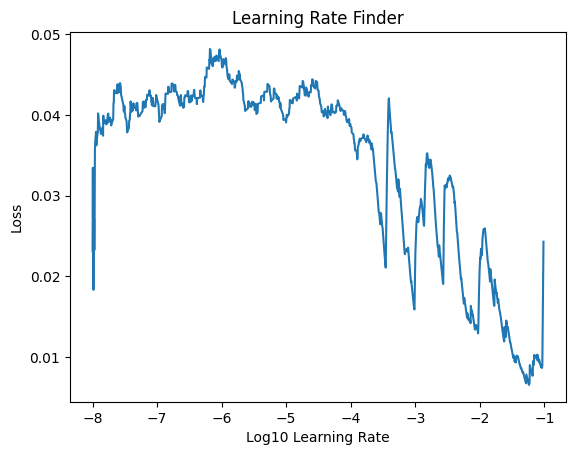

In [ ]:

dictionary_file_location ='/content/drive/MyDrive/Anand_Trexquant/words_250000_train.txt'
#def build_dictionary( full_dictionary_location):
text_file = open(dictionary_file_location,"r")
full_dictionary = text_file.read().splitlines()
text_file.close()
full_dictionary

'''
type(full_dictionary)
word_list = ["ability", "absence", "academy", "account", "accuracy", "activity",
             "actually", "addition", "address", "admission", "advantage", "advice",
             "adviser", "affect", "afternoon", "situation", "associate", "attention",
             "attitude", "attribute", "audience", "authority", "available", "awareness",
             "beautiful", "certainly", "challenge", "character", "chocolate", "collection",
             "commercial", "committee", "community", "completely", "complex", "component",
             "conclusion", "condition", "conference", "confidence", "connection", "consciousness",
             "consider", "consistent", "constant", "construction", "contain", "content",
             "contribute", "contribution", "control", "conversation", "cooperation", "corporation",
             "cultural", "currently", "dangerous", "definition", "demonstrate", "department",
             "dependent", "designer", "determine", "developer", "development", "difference",
             "difficulty", "dimension", "direction", "director", "disappear", "discipline",
             "discovery", "discussion", "distribute", "distribution", "diversity", "education",
             "efficiency", "electronic", "employment", "encourage", "engineer", "entertainment",
             "environment", "especially", "establish", "evaluation", "eventually", "everybody",
             "everything", "evidence", "exactly", "examination"]
'''
agent = HangmanDQL(full_dictionary)
agent.populate_memory(games=1000)
log_lrs, losses = agent.find_learning_rate()
agent.plot_lr_finder(log_lrs, losses)



In [ ]:
agent = HangmanDQL(full_dictionary)
agent.train(epochs=5000)
success_count = agent.test(games=100)
print(success_count)

Training Epoch: 1/5000
Success rate: 0.00%
Training Epoch: 2/5000
Success rate: 0.20%
Training Epoch: 3/5000
Success rate: 0.20%
Training Epoch: 4/5000
Success rate: 0.20%
Training Epoch: 5/5000
Success rate: 0.00%
Training Epoch: 6/5000
Success rate: 0.00%
Training Epoch: 7/5000
Success rate: 0.80%
Training Epoch: 8/5000
Success rate: 0.00%
Training Epoch: 9/5000
Success rate: 0.00%
Training Epoch: 10/5000
Success rate: 0.40%
Training Epoch: 11/5000
Success rate: 0.00%
Training Epoch: 12/5000
Success rate: 0.00%
Training Epoch: 13/5000
Success rate: 0.60%
Training Epoch: 14/5000
Success rate: 0.60%
Training Epoch: 15/5000
Success rate: 0.00%
Training Epoch: 16/5000
Success rate: 0.60%
Training Epoch: 17/5000
Success rate: 0.40%
Training Epoch: 18/5000
Success rate: 0.20%
Training Epoch: 19/5000
Success rate: 0.20%
Training Epoch: 20/5000
Success rate: 0.40%
Training Epoch: 21/5000
Success rate: 0.60%
Training Epoch: 22/5000
Success rate: 0.40%
Training Epoch: 23/5000
Success rate: 0.4